## 청라, 송도지역 미세먼지 측정값 스크래핑
> 1. 송도 = https://bit.ly/2EWi9vM
> 1. 청라 = https://bit.ly/2Al7h6y

* Todo: 계측 센서 갯수가 다르므로 필터링 방식이 달라져야 한다
* 송도 = 6개 / 청라 = 4개

In [1]:
"""
* 청라, 송도지역 미세먼지 측정값 스크래핑
"""
import os
import sys
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import requests
from bs4 import BeautifulSoup

## 작업폴더 지정
 - static = 정적화일 저장
     - data = 'csv' 실시간 스크랩을 저장 하는 곳 (24~최대 48개 수집)
         'air_20190107_1500_Mon.csv'
         - collect = 'csv' 화일을 합쳐서, 최종본만 저장 
         - trash = 힙치고 남은 가비지를 임시로 옮겨두는곳
     - html
     - img
         - nulschool = 널스쿨 이미지 캡춰장소
         - test = 실시간 분석 결과를 저장 (24~48)
         

In [2]:
dir_work = os.getcwd()

# data 자동저장 폴더
dir_data = os.path.join(dir_work, *['static', 'data',])
dir_data_collect = os.path.join(dir_work, *['static', 'data', 'collect',])
dir_data_trash   = os.path.join(dir_work, *['static', 'data', 'trash',])

# 이미지 결과 자동저장 폴더
dir_img = os.path.join(dir_work, *['static', 'img',])
dir_img_heatmap = os.path.join(dir_work, *['static', 'img', 'heatmap',])
dir_img_nulschool = os.path.join(dir_work, *['static', 'img', 'nulschool',])
dir_img_plot_plot = os.path.join(dir_work, *['static', 'img', 'plot_plot',])
dir_img_plot_scatter = os.path.join(dir_work, *['static', 'img', 'plot_scatter',])
dir_img_test = os.path.join(dir_work, *['static', 'img', 'test',])

In [3]:
# NOW_DATE
# datetime.datetime.now() # ... datetime.datetime(2019, 1, 7, 18, 21, 13, 734730)

NOW_DATE = datetime.datetime.strftime(
                    datetime.datetime.now(),
                    '%Y%m%d_%a_%H00',
                    )                       # '20190107_Mon_1800'

YEAR = NOW_DATE[:4]
MONTH= NOW_DATE[4:6]
DAY  = NOW_DATE[6:8]
WEEK = NOW_DATE[9:12]
HOUR = NOW_DATE[-4:-2]

SAVE_LOG  = f"{YEAR}{MONTH}{DAY}_{WEEK}_{HOUR}00"     #'20190107_Mon_1800'
SAVE_LOG1 = f"{YEAR}{MONTH}{DAY}_{HOUR}00_{WEEK}"     #'20190107_1800_Mon'

In [4]:
print(f"The Last ... {NOW_DATE} \n")


print(f"마지막 기록 = {YEAR}년 {MONTH}월 {DAY}일 ({WEEK}) {HOUR}:00")
print(SAVE_LOG)

The Last ... 20190107_Mon_1800 

마지막 기록 = 2019년 01월 07일 (Mon) 18:00
20190107_Mon_1800


In [5]:
URLS = [
    'http://air.incheon.go.kr/airinch/real3.html?area_other_index=999991',
    'http://air.incheon.go.kr/airinch/real3.html?area_other_index=999992',
]

""" 주의!: 송도와 청라는 데이터 갯수가 틀려서 필터링 방법을 달리해야 함. """
URL = URLS[0]  # 0=청라 - 측정치 1+3 = 4개
URL = URLS[1]  # 1=송도 - 측정치 1+6 = 7개

RESPONSE = requests.get(URL)
SOUP = BeautifulSoup(RESPONSE.content, 'html.parser')
TABLE = SOUP.find_all('table', {'class': 'view'})

TDS = TABLE[0].find_all('td')
FONTS = TABLE[0].find_all('font')
SPANS = TABLE[0].find_all('span')

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


## 데이터의 길이를 기준으로 구분한다 (EDA)
> 12자 길이를 넘어가는 데이터는 한글 테이터이다.

In [6]:
for n, span in enumerate(SPANS, 0):
    neat_span = str(span.text).strip()   

In [7]:
DATE = []       # 날짜정보 2개를 담음.
DATA = []       # 스크랩핑한 전체 데이터 = 헤드정보 포함

In [8]:
for n, span in enumerate(SPANS, 0):
    neat_span = str(span.text).strip()

    if len(neat_span) > 12:                           # 2018년12월 29일24시
        """ 날짜와 시간을 분리해서 각각 넣는다 """
        DATE.append(neat_span[:-3])     # 날짜 = 2018년 12월 29일
        DATA.append(neat_span[-3:])     # 시간 = '24시'  .. 날짜는 잘라내고, 시간만 넣는다
    else:
        DATA.append(neat_span)          # 그렇지 않으면 그냥 넣는다

""" 리스트에 담긴 해당 날짜를 보여준다, 그래봤자 2개 지만.. """
1. print(DATE[0])                          # 2018년12월 30일  ... 오늘날짜가 먼저 담긴다.
1. print(DATE[1])                          # 2018년12월 29일  ... 어제날짜가 다음에 담긴다.

In [9]:
DATE
# '2019년01월\xa003일', '2019년01월\xa002일']

# DATA[:8]
# ['시간', '측정항목', 'SO2(ppm)', 'NO2(ppm)', 'O3(ppm)', 'CO(ppm)', 'PM10(㎍/㎥)', 'PM2.5(㎍/㎥)', 
#  '11시', '0.009', '0.056',..... ]
# 맨 앞의 8자리 해더정보를 잘라내고 데이터만 DATA 에 담는다

['2019년01월\xa007일', '2019년01월\xa006일']

In [10]:
DATE[0]     # 오늘 ... '2019년01월\xa003일'
DATE[1]     # 어제 ... '2019년01월\xa002일'
FORMAT_DATE = []

for date in DATE:
    YEAR =  date[:4]     # '2009'
    MONTH = date[5:7]    # '01'
    DAY =   date[9:-1]   # '03'
    FORMAT_DATE.append(f'{YEAR}-{MONTH}-{DAY}')             

FORMAT_DATE.reverse()   # ['2019-01-02', '2019-01-03']

In [11]:
FORMAT_DATE

['2019-01-06', '2019-01-07']

In [12]:
FULL_COLUMNS = ['Time(24Hr)',]
FULL_COLUMNS.extend(DATA[2:8])  # ['Time(24Hr)','SO2(ppm)', ... 'CO(ppm)','PM10(㎍/㎥)','PM2.5(㎍/㎥)']

## COLUMNS, UNIT, TIME_COLS
1. COLUMNS = ['Time', 'SO2', 'NO2', 'O3', 'CO', 'PM10', 'PM2.5'],
1. UNITS = ['24Hr', 'ppm', 'ppm', 'ppm', 'ppm', '㎍/㎥', '㎍/㎥'])    
1. TIME_COLS = ['01', '02', ... '12', '01',]
1. FORMAT_DATE = ['2019-01-02', '2019-01-03']  ... 순서대로 재배열

In [13]:
COLUMNS = []       # 컬럼 제목들 만 뽑는다.
UNITS = []         # 컬럼 단위들 만 뽑는다.

for item in FULL_COLUMNS:      # full 컬럼값에서 '타이틀'과 '단위'를 분리해 냄
    title = item.split('(')[0]    # Title
    _rest = item.split('(')[1]
    
    COLUMNS.append(title)
    UNITS.append(_rest[:-1])

In [14]:
CUT_DATA = DATA[8:]                       # 앞 부분(index header)을 잘라내고 데이터부분만 남김 =  1-DIM
DATA_NP = np.array(CUT_DATA)              # numpy 데이터 변환!
DATA_NP2D = np.reshape(DATA_NP, (-1,7))   # 1D to 2D 변환 (-1,7)
# np.shape(a=DATA_NP2D)                     # (26,7)  ... 그때 그때 행이 바뀜, 최대 24~ 48까지
DATA_NP2D

array([['18시', '0.008', '0.024', '0.030', '0.9', '57', '35'],
       ['17시', '0.008', '0.022', '0.033', '0.9', '54', '35'],
       ['16시', '0.009', '0.021', '0.033', '0.9', '56', '35'],
       ['15시', '0.010', '0.029', '0.024', '0.8', '55', '33'],
       ['14시', '0.009', '0.028', '0.023', '0.9', '59', '39'],
       ['13시', '점검', '점검', '점검', '점검', '점검', '점검'],
       ['12시', '점검', '점검', '점검', '점검', '점검', '점검'],
       ['11시', '0.008', '0.057', '0.006', '0.9', '66', '41'],
       ['10시', '0.008', '0.065', '0.003', '1.1', '69', '43'],
       ['09시', '0.007', '0.060', '0.003', '1.1', '56', '36'],
       ['08시', '0.007', '0.059', '0.002', '1.0', '51', '32'],
       ['07시', '0.007', '0.058', '0.002', '1.1', '54', '34'],
       ['06시', '0.007', '0.047', '0.003', '0.8', '51', '32'],
       ['05시', '0.007', '0.041', '0.003', '0.7', '49', '33'],
       ['04시', '0.006', '0.045', '0.002', '0.7', '46', '31'],
       ['03시', '0.006', '0.034', '0.009', '0.6', '51', '31'],
       ['02시', '0.006', '0.0

In [15]:
TIME_COLS = DATA_NP2D[:,0]                         # 시간 1열만 쪼개서 따로 담음 .. '08시'
DATA_NP2D[:,0] = [time[:2] for time in TIME_COLS]  # 02시 --> 02, 앞 두글자만 잘라냄
DATA_NP2D[:10]

array([['18', '0.008', '0.024', '0.030', '0.9', '57', '35'],
       ['17', '0.008', '0.022', '0.033', '0.9', '54', '35'],
       ['16', '0.009', '0.021', '0.033', '0.9', '56', '35'],
       ['15', '0.010', '0.029', '0.024', '0.8', '55', '33'],
       ['14', '0.009', '0.028', '0.023', '0.9', '59', '39'],
       ['13', '점검', '점검', '점검', '점검', '점검', '점검'],
       ['12', '점검', '점검', '점검', '점검', '점검', '점검'],
       ['11', '0.008', '0.057', '0.006', '0.9', '66', '41'],
       ['10', '0.008', '0.065', '0.003', '1.1', '69', '43'],
       ['09', '0.007', '0.060', '0.003', '1.1', '56', '36']], dtype='<U5')

In [16]:
DATA_NP2D_FLIPED = np.flip(DATA_NP2D, 0)    # 0=상하플립

DATA_NUM = len(DATA_NP2D_FLIPED)
INDEX = []

for i in range(DATA_NUM):
    if i < 23:
        INDEX.append(f'{FORMAT_DATE[0]}-{i+1:02}')
    else:
        INDEX.append(f'{FORMAT_DATE[1]}-{i-24+1:02}')
INDEX    # ['2019-01-02-01', '2019-01-02-02',


DATA_NP2D_FLIPED_LIST = DATA_NP2D_FLIPED.tolist()


for i in range(DATA_NUM):
   DATA_NP2D_FLIPED_LIST[i][0] = INDEX[i]

DATA_NP2D_FLIPED_LIST[:10]

[['2019-01-06-01', '0.007', '0.024', '0.016', '0.7', '52', '19'],
 ['2019-01-06-02', '0.009', '0.025', '0.015', '0.6', '53', '20'],
 ['2019-01-06-03', '0.009', '0.023', '0.017', '0.7', '56', '23'],
 ['2019-01-06-04', '0.008', '0.020', '0.020', '0.6', '59', '23'],
 ['2019-01-06-05', '0.008', '0.023', '0.017', '0.6', '59', '26'],
 ['2019-01-06-06', '0.008', '0.025', '0.016', '0.6', '58', '24'],
 ['2019-01-06-07', '0.008', '0.036', '0.007', '0.7', '56', '23'],
 ['2019-01-06-08', '0.008', '0.039', '0.005', '0.6', '54', '22'],
 ['2019-01-06-09', '0.010', '0.035', '0.008', '0.6', '54', '23'],
 ['2019-01-06-10', '0.013', '0.033', '0.010', '0.7', '64', '29']]

In [17]:
DATA_NP2D_FLIPED = np.array(DATA_NP2D_FLIPED_LIST)
DATA_NP2D_FLIPED[:4]

array([['2019-01-06-01', '0.007', '0.024', '0.016', '0.7', '52', '19'],
       ['2019-01-06-02', '0.009', '0.025', '0.015', '0.6', '53', '20'],
       ['2019-01-06-03', '0.009', '0.023', '0.017', '0.7', '56', '23'],
       ['2019-01-06-04', '0.008', '0.020', '0.020', '0.6', '59', '23']],
      dtype='<U13')

In [18]:
DATA_NP2D_FLIPED[-4:-1]

array([['2019-01-07-15', '0.010', '0.029', '0.024', '0.8', '55', '33'],
       ['2019-01-07-16', '0.009', '0.021', '0.033', '0.9', '56', '35'],
       ['2019-01-07-17', '0.008', '0.022', '0.033', '0.9', '54', '35']],
      dtype='<U13')

In [19]:
# DATA_NP2D (String) 은 원본으로 남겨두고, Float 숫자로 변환하여 AIR_DATA_NP로 변경 
# AIR_DATA_NP = np.asfarray(DATA_NP2D, dtype=np.float)  # 문자열 --> float 로 변경해 줌(1)
AIR_DATA_NP = DATA_NP2D_FLIPED
AIR_DATA_NP[:5]

array([['2019-01-06-01', '0.007', '0.024', '0.016', '0.7', '52', '19'],
       ['2019-01-06-02', '0.009', '0.025', '0.015', '0.6', '53', '20'],
       ['2019-01-06-03', '0.009', '0.023', '0.017', '0.7', '56', '23'],
       ['2019-01-06-04', '0.008', '0.020', '0.020', '0.6', '59', '23'],
       ['2019-01-06-05', '0.008', '0.023', '0.017', '0.6', '59', '26']],
      dtype='<U13')

In [20]:
df = pd.DataFrame(AIR_DATA_NP, columns=COLUMNS)

print(df.columns)
print(df.index, end='\n\n')

print(df.head(3))
print(df.tail(3), end='\n\n')

print(df.info())

Index(['Time', 'SO2', 'NO2', 'O3', 'CO', 'PM10', 'PM2.5'], dtype='object')
RangeIndex(start=0, stop=42, step=1)

            Time    SO2    NO2     O3   CO PM10 PM2.5
0  2019-01-06-01  0.007  0.024  0.016  0.7   52    19
1  2019-01-06-02  0.009  0.025  0.015  0.6   53    20
2  2019-01-06-03  0.009  0.023  0.017  0.7   56    23
             Time    SO2    NO2     O3   CO PM10 PM2.5
39  2019-01-07-16  0.009  0.021  0.033  0.9   56    35
40  2019-01-07-17  0.008  0.022  0.033  0.9   54    35
41  2019-01-07-18  0.008  0.024  0.030  0.9   57    35

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 7 columns):
Time     42 non-null object
SO2      42 non-null object
NO2      42 non-null object
O3       42 non-null object
CO       42 non-null object
PM10     42 non-null object
PM2.5    42 non-null object
dtypes: object(7)
memory usage: 2.4+ KB
None


# '점검' 이 발생하면, 값을 대치(Replace)한다
[R, Python 분석과 프로그래밍 (by R Friend)]](http://rfriend.tistory.com/262)
- 결측값 채우기, 결측값 대체하기, 결측값 처리 
- filling missing value, imputation of missing values) : df.fillna()

1. null 값으로 대치 = 그래프에 너무 큰 변화가 온다 ... NG

> - 앞, 뒤 값의 평균값으로 대치한다. = 변화를 눈치채기 힘들다.
> - 앞의 값으로 대치한다. = 언제든 대치 가능
> - 뒤의 값으로 대치한다. = 뒤에 센서값이 들어와야 대치 가능
>> 1. 점검이 발행하면 2~3시간 소요된다.
>> 1. 2~3 시간동안 평행한 직선으로 진행된다.

In [21]:
hit_manage = len(df[df.PM10.values == '점검'].values)
print(hit_manage)


if hit_manage:
    df = df.replace('점검', 0)
    print("'점검'are DELETED! ")
    
df[df.PM10.values == 0]   # 0 으로 교체된 부분 표시

2
'점검'are DELETED! 


,Time,SO2,NO2,O3,CO,PM10,PM2.5
35,2019-01-07-12,0,0,0,0,0,0
36,2019-01-07-13,0,0,0,0,0,0


In [22]:

# df.columns   # Index(['Time', 'SO2', 'NO2', 'O3', 'CO', 'PM10', 'PM2.5'], dtype='object')

for col in list(df.columns)[1:]:
    df[col] = pd.to_numeric(df[col])
    
df['Time'] = pd.to_datetime(df['Time'])    
    
    
# Dtype 변환 확인
# type(df['PM10'][0])      # numpy.int64
# type(df['PM2.5'][0])     # numpy.int64
# TEST ... Time Format

# time_format = '%d/%m/%y %H:00'
TIME_FORMAT = '%Y.%m/%d(%a)-%H:00'
TIMES = [ datetime.datetime.strftime(timestamp, TIME_FORMAT) for timestamp in df.Time.tolist()]
df['TIMES'] = TIMES
df.head()

,Time,SO2,NO2,O3,CO,PM10,PM2.5,TIMES
0,2019-01-06 01:00:00,0.007,0.024,0.016,0.7,52,19,2019.01/06(Sun)-01:00
1,2019-01-06 02:00:00,0.009,0.025,0.015,0.6,53,20,2019.01/06(Sun)-02:00
2,2019-01-06 03:00:00,0.009,0.023,0.017,0.7,56,23,2019.01/06(Sun)-03:00
3,2019-01-06 04:00:00,0.008,0.020,0.020,0.6,59,23,2019.01/06(Sun)-04:00
4,2019-01-06 05:00:00,0.008,0.023,0.017,0.6,59,26,2019.01/06(Sun)-05:00


In [23]:
# 그래프 함수의 정의

def df_plot(df_column): 
    # plt.figure(figsize=(10,4))
    plt.plot(df_column)
    """ 그래프에 텍스트를 입히는 옵션 """
    plt.title("DATA PLOTTING")        # 타이틀
    plt.xlabel(COLUMNS[:1])                      # x 라벨
    plt.ylabel(df_column.name)                   # y 라벨
    plt.legend()
    plt.xticks(df.index, df.TIMES, rotation=90)
    
def df_hist(df_column):
    plt.hist(df_column, alpha=0.7)
    """ 그래프에 텍스트를 입히는 옵션 """
    plt.title("DATA HISTOGRAM")        # 타이틀
    plt.xlabel(COLUMNS[:1])                      # x 라벨
    plt.ylabel(df_column.name)                   # y 라벨
    
    
def df_scatter(df_col1, df_col2):
    plt.scatter(df_col1, df_col2,alpha=0.2)
    """ 그래프에 텍스트를 입히는 옵션 """
    plt.title(
        "SCATTER CHART with {},{}".format(
            df_col1.name, 
            df_col2.name,))        # 타이틀
    plt.xlabel(df_col2.name)                     # x 라벨
    plt.ylabel(df_col1.name)                     # y 라벨
    
def plot_2charts(data_series, xlabel):  
    """
    # 히스토그램 + 박스플롯을 4x4화면 윗쪽 2개로 플롯해줍니다.
    """
    plt.figure()
    plt.subplot(221)
    plt.hist(data_series)
    plt.xlabel(xlabel)
    
    plt.subplot(222)
    sns.boxplot(data_series)
    plt.show()    

In [24]:
def plot_detail(pd_series, color='blue', marker='^', linestyle='--', xtick_interval=2, ytick_interval=5,):
    """
    style = color='blue', marker='^', linestyle='--'   ... default style
    linestyle = '-', '--', '-.', ':', '', (offset, on-off-seq), ...
    marker_style = '.', ',', 'o', 'v', '^', '<', '>', '1', '2', '3', '4', 
                    's', 'p', '*', 'h', 'H', '+', 'x', 'D', 'd', '|', '_', 
    xtick_interval = 2, ytick_interval = 5
    https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html?highlight=plot%20color
    """
    this_func_name = sys._getframe().f_code.co_name
    ytick_start = pd_series.min() - (pd_series.min() % ytick_interval)
    ytick_end = pd_series.max() - (pd_series.max() % ytick_interval) + ytick_interval

    sorted_ytick_label = sorted([
            *np.arange(ytick_start, ytick_end, ytick_interval).tolist(), 
            pd_series.min(), 
            pd_series.max(), 
            pd_series.mean(), 
            pd_series.median()])

    plt.figure(figsize=(10,4))
   
    plt.plot(pd_series, color=color, marker=marker, linestyle=linestyle)
    plt.yticks(sorted_ytick_label, rotation=0)
    plt.xticks(df.index, df.TIMES, rotation=90)
    plt.title(f'funcname={this_func_name} -- {pd_series.name}')
    plt.legend()
    plt.grid()

## 데이터 분포형상 확인
 ['SO2', 'NO2', 'O3', 'CO', 'PM10', 'PM2.5']

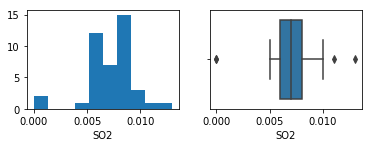

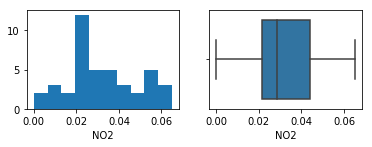

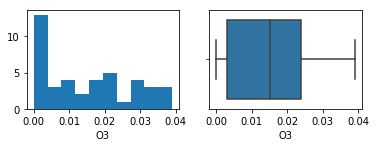

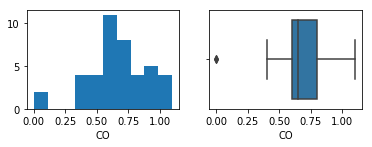

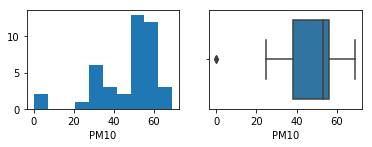

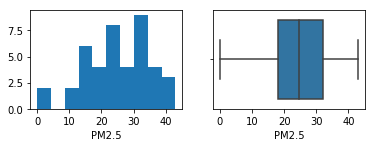

In [25]:
for item in COLUMNS[1:]:
    plot_2charts(data_series=df[item], xlabel=item)

In [26]:
# CO값 차이가 커서,(9로 나눠서 한 그래프에 표시)..['SO2', 'NO2', 'O3', 'CO_mod',]
# df 에 'NEW'칼럼 추가하기 (df.CO값을 복사해서 칸을 늘림)
df['CO_mod'] = pd.Series(df['CO'].copy() / 11, index=df.index)            # CO를    1/12
df['PM10_mod'] = pd.Series(df['PM10'].copy() / 250, index=df.index)       # PM10을  1/250
df['PM2.5_mod'] = pd.Series(df['PM2.5'].copy() / 120, index=df.index)     # PM2.5를 1/120

In [27]:
# 전체 통계정보 보기
df.describe()

,SO2,NO2,O3,CO,PM10,PM2.5,CO_mod,PM10_mod,PM2.5_mod
count,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000
mean,0.007262,0.031762,0.015167,0.661905,47.333333,24.761905,0.060173,0.189333,0.206349
std,0.002317,0.016758,0.012384,0.239870,15.431464,9.945730,0.021806,0.061726,0.082881
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.006000,0.021250,0.003000,0.600000,38.000000,18.250000,0.054545,0.152000,0.152083
50%,0.007000,0.028500,0.015000,0.650000,53.000000,24.500000,0.059091,0.212000,0.204167
75%,0.008000,0.044000,0.023750,0.800000,56.000000,32.000000,0.072727,0.224000,0.266667
max,0.013000,0.065000,0.039000,1.100000,69.000000,43.000000,0.100000,0.276000,0.358333


In [28]:
# 데이터간 연계성(Correlation) 확인 

chk_columns = ['SO2', 'NO2', 'O3', 'CO', 'PM10', 'PM2.5',]
chk_dfs = pd.DataFrame(df[col] for col in chk_columns)

chk_dfs.T.head(5)   # 방향을 transpose() 시켜줘야 함
chk_dfs.T.corr()

,SO2,NO2,O3,CO,PM10,PM2.5
SO2,1.000000,0.232805,0.209243,0.527440,0.843350,0.599700
NO2,0.232805,1.000000,-0.657847,0.771323,0.514631,0.687307
O3,0.209243,-0.657847,1.000000,-0.200615,-0.061943,-0.198091
CO,0.527440,0.771323,-0.200615,1.000000,0.765885,0.904982
PM10,0.843350,0.514631,-0.061943,0.765885,1.000000,0.849945
PM2.5,0.599700,0.687307,-0.198091,0.904982,0.849945,1.000000


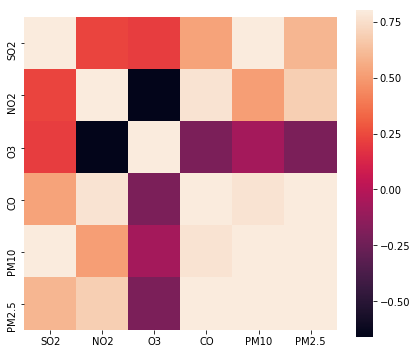

In [29]:
# Correlation Heatmap 확인 (양/음의 관계 강도를 이미지로 보여줌)
# sns.heatmap(chk_dfs.T.corr())

f, ax = plt.subplots(figsize=(7,6))
sns.heatmap(chk_dfs.T.corr(), vmax=.8, square=True)
plt.savefig(dir_img_heatmap + f'/heatmap_{SAVE_LOG1}.png')

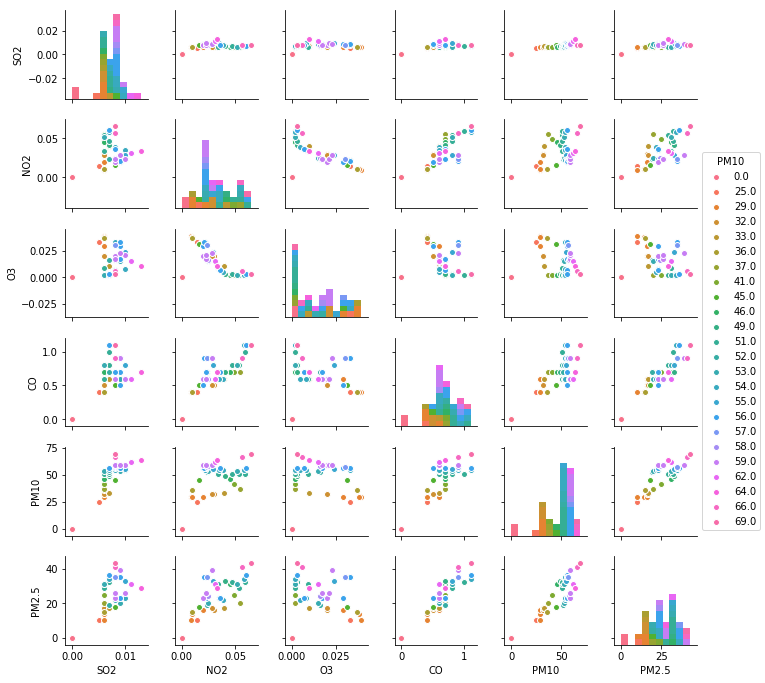

In [30]:
# 전체 분포 및 데이터의 연관성을 보기위해, 타겟 = PM10으로 놓고, 분포확인
# example = https://seaborn.pydata.org/generated/seaborn.pairplot.html

sns.pairplot(chk_dfs.T, hue='PM10', palette="husl", size=1.6)        # size in inches of each pnnel
plt.savefig(dir_img_plot_plot + f'/pairplot_{SAVE_LOG1}.png')

plt.show()

## 전체 센서값 동향 플로팅
 - ['Time', 'SO2', 'NO2', 'O3', 'CO', 'PM10', 'PM2.5']
 - 6개 센서값이 일별 반복패턴을 보임 = 일별 반복패턴의 영향인자? 
 - --> 바람(육풍/해풍)?, 출근시간?, 공장가동시간?, 교통량? 등 ... 확인필요!)
 - 년간 동향을 분석하면 계절별 패턴이 나옴 --> 년간 영향인자 분석!
 - --> 바람(편서풍)?, 기온? 중국의 기상인자? 중국 미세먼지(PM10,2.5)유입, 중앙아시아 사막, 기온(빙점기준)

In [31]:
!dir

 C 드라이브의 볼륨: Yoga_256G
 볼륨 일련 번호: 3CAA-9005

 C:\Users\nitt0\Documents\Github\web_beautifulsoup_scrapping\jupyter_air 디렉터리

2019-01-07  오후 06:53    <DIR>          .
2019-01-07  오후 06:53    <DIR>          ..
2019-01-07  오후 01:17    <DIR>          .ipynb_checkpoints
2019-01-07  오후 03:48            49,433 air_data_collector.ipynb
2018-12-30  오후 07:43           266,667 air_incheon_bs4_00.ipynb
2019-01-04  오전 08:25           340,319 air_incheon_bs4_r01_foat64.ipynb
2019-01-07  오후 06:53           683,345 air_incheon_bs4_r02_reverse.ipynb
2019-01-06  오후 10:37            92,318 air_incheon_overall_r00.ipynb
2019-01-07  오전 11:23    <DIR>          asset
2019-01-07  오전 11:42    <DIR>          static
2019-01-07  오후 03:24            50,034 test_pandas.ipynb
2019-01-07  오후 01:58             2,125 xls_read_made_data.ipynb
               7개 파일           1,484,241 바이트
               5개 디렉터리  121,648,418,816 바이트 남음


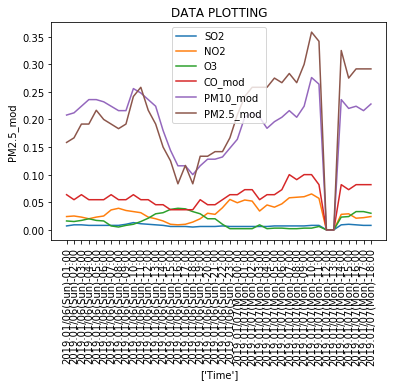

In [32]:
[df_plot(df[col]) for col in ['SO2', 'NO2', 'O3', 'CO_mod','PM10_mod', 'PM2.5_mod',]]
plt.savefig(dir_img_plot_plot + f'/plot_all_6_{SAVE_LOG1}.png')

plt.show()

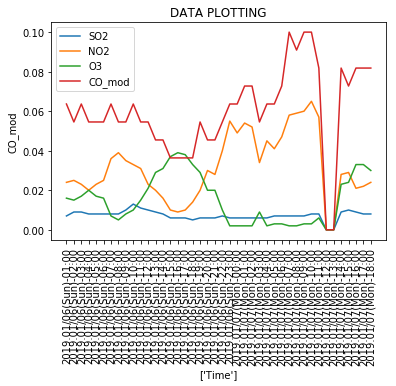

In [33]:
[df_plot(df[col]) for col in ['SO2', 'NO2', 'O3', 'CO_mod',]]
plt.savefig(dir_img_plot_plot + f'/plot_comp4_{SAVE_LOG1}.png')
plt.show()

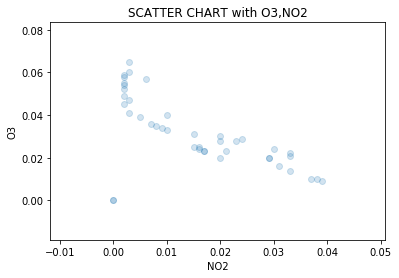

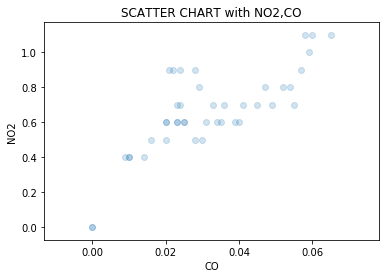

In [34]:
df_scatter(df.O3, df.NO2)
plt.show()

df_scatter(df.NO2, df.CO)
plt.show()

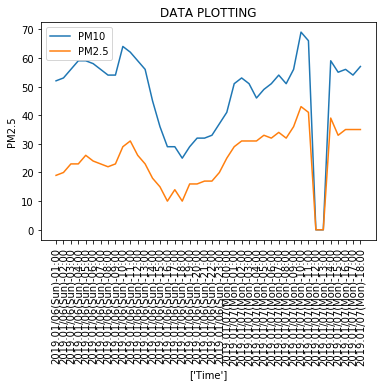

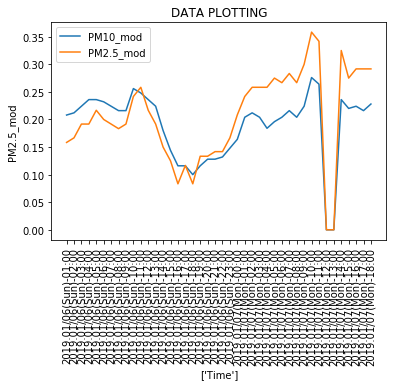

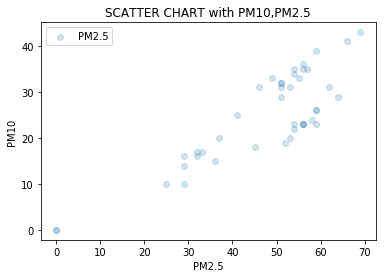

In [35]:
[df_plot(df[col]) for col in ['PM10', 'PM2.5']]
plt.show()

[df_plot(df[col]) for col in ['PM10_mod', 'PM2.5_mod']]
plt.show()

# 스케터는 플립이 필요없음!
df_scatter(df.PM10, df['PM2.5'])
plt.legend()

## 플립하지 말아야 할 그래프

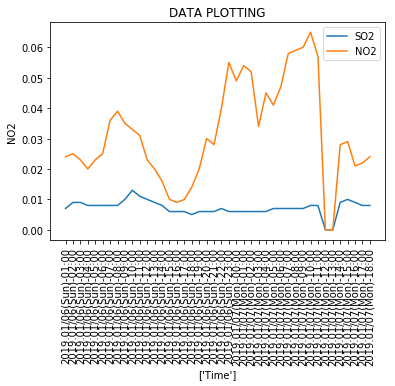

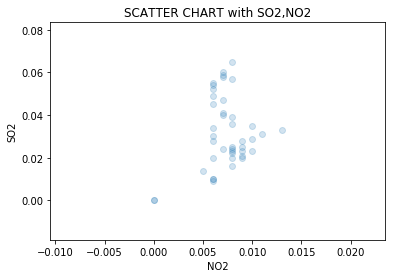

In [36]:
[df_plot(df[col]) for col in ['SO2', 'NO2']]
plt.show()

# 스캐터는 플립할 필요가 없음
df_scatter(df.SO2, df.NO2)
plt.show()

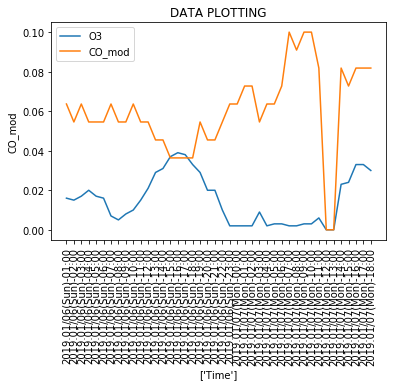

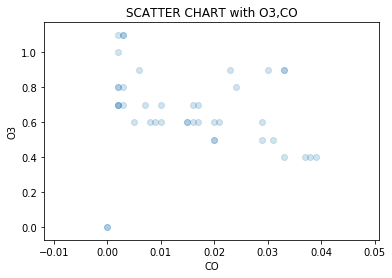

In [37]:
# 전체 플로팅 중에 관심사항만 따로 플로팅 해서 관찰하기
# [df_plot(df[col]) for col in ['SO2', 'NO2', 'O3', 'CO', 'PM10', 'PM2.5']]
# plt.show()

[df_plot(df[col]) for col in ['O3', 'CO_mod',]]
plt.show()

# 스캐터는 플립필요없음!
df_scatter(df.O3, df.CO)
plt.show()

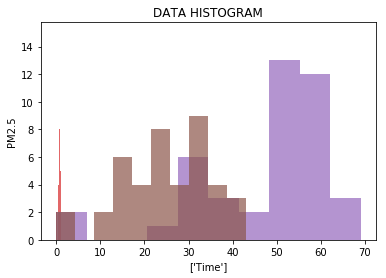

In [38]:
[df_hist(df[col]) for col in ['NO2', 'SO2', 'O3', 'CO', 'PM10', 'PM2.5']]
plt.savefig(dir_img_plot_scatter + f'/plot_6hist_{SAVE_LOG1}.png')

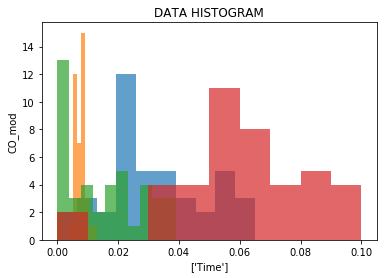

In [39]:
[df_hist(df[col]) for col in ['NO2', 'SO2', 'O3', 'CO_mod']]
plt.savefig(dir_img_plot_scatter + f'/plot_4hist_modf_{SAVE_LOG1}.png')

# http://www.airkorea.or.kr/index
- TODO: 웹에서 이미지 다운 / 또는 캡처해서 실시간 영상제공!

| **대쉬보드** | ---- | **센서값** |
|:-------|:----:|:-------|
| ![](./static/img/air_korea_index.png) | ... | ![](./static/img/air_korea_pm_dashboard.png) | 


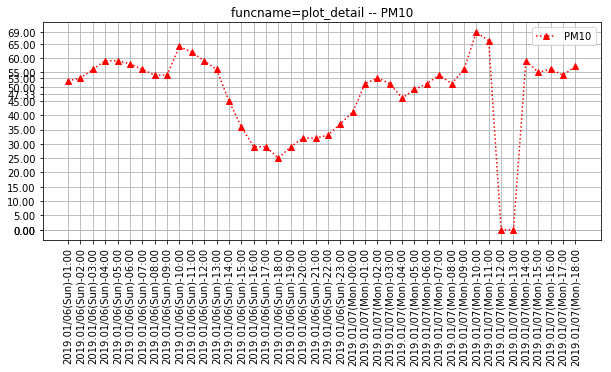

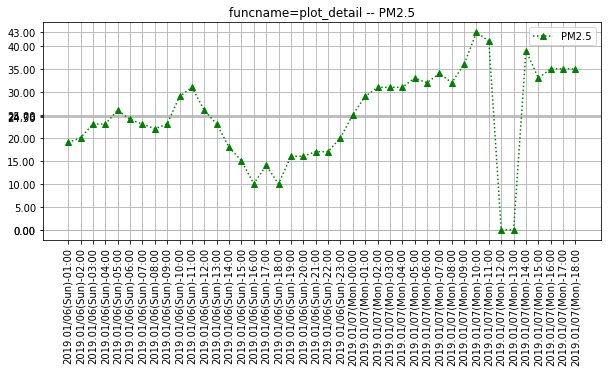

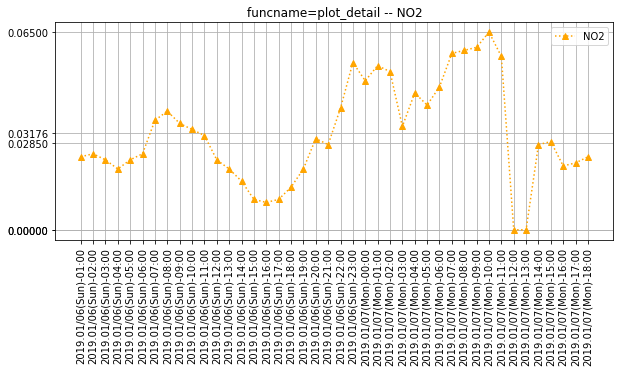

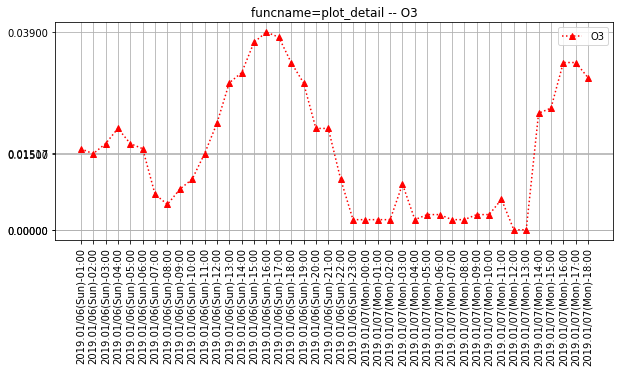

In [40]:
plot_detail(df['PM10'],'red','^',':')
plt.savefig(dir_img_plot_plot + f'/plot_PM10_{SAVE_LOG1}.png')
plt.show()

plot_detail(df['PM2.5'],'green','^',':')
plot_detail(df['NO2'],'orange','^',':')
plot_detail(df['O3'],'red','^',':')
plt.show()

# https:// earth.nullschool.net
- 현재 우리나라 현재상황 [지도](http://bit.ly/2SxRmc4)
- TODO: 웹에서 이미지 다운 / 또는 캡처해서 실시간 영상제공!

| **2019 1/4(월)** | **4시간 간격 기상변화** |
|:--:|:--:|
| <img src='./static/img/nulschool/20190104_0800_nulschool.png'> | <img src='./static/img/nulschool/20190104_1300_nulschool.png'> |
| 20190104_0800 | 20190104_1300 |
| <img src='./static/img/nulschool/20190104_1700_nulschool.png'> | <img src='./static/img/nulschool/20190104_2100_nulschool.png'> |
| 20190104_1700 | 20190104_2100 |
| <img src='./static/img/nulschool/20190104_2300_nulschool.png'> | <img src='./static/img/nulschool/20190105_0200_nulschool.png'> |
| 20190104_2300 (?) 갱신주기가 안맞나? 동일영상?!!(3시간) | 20190105_0200 드디어 갱신됬다! |
| <img src='./static/img/nulschool/20190105_0900_nulschool.png'> | <img src='./static/img/nulschool/20190105_1200_nulschool.png'> |
| 20190105_0900 격변기! (히드맵 확인) | 20190105_1200 (버거킹에서)?|
| <img src='./static/img/nulschool/20190105_1600_nulschool.png'> | <img src='./static/img/nulschool/20190105_2000_nulschool.png'> |
| 20190105_1600 토요스터디 중에 | 20190105_2000 4시간간격 열심히!!(수공예)|
| <img src='./static/img/nulschool/20190106_1300_nulschool.png'> | <img src='./static/img/nulschool/20190106_1600_nulschool.png'> |
| 20190106_1300 밥먹으러 나옴 | 20190106_1600|

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 11 columns):
Time         42 non-null datetime64[ns]
SO2          42 non-null float64
NO2          42 non-null float64
O3           42 non-null float64
CO           42 non-null float64
PM10         42 non-null int64
PM2.5        42 non-null int64
TIMES        42 non-null object
CO_mod       42 non-null float64
PM10_mod     42 non-null float64
PM2.5_mod    42 non-null float64
dtypes: datetime64[ns](1), float64(7), int64(2), object(1)
memory usage: 3.7+ KB


In [42]:
dfn = df.drop_duplicates(
            subset='TIMES', 
            keep='first',
        )\

    .filter(
        items=[
            'TIMES', 
            'Time', 
            'SO2', 
            'NO2', 
            'O3', 
            'CO', 
            'PM10', 
            'PM2.5'],
        )\

    .sort_values(
            by=['TIMES'], 
            ascending=1, 
            axis=0,
        )\

    .set_index('TIMES')

dfn.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42 entries, 2019.01/06(Sun)-01:00 to 2019.01/07(Mon)-18:00
Data columns (total 7 columns):
Time     42 non-null datetime64[ns]
SO2      42 non-null float64
NO2      42 non-null float64
O3       42 non-null float64
CO       42 non-null float64
PM10     42 non-null int64
PM2.5    42 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(2)
memory usage: 2.6+ KB


In [43]:
# Data Frame 을 엑셀로 저장한다. (CSV화일)
dfn.to_csv(dir_data + f'/{SAVE_LOG}_air_incheon.csv', sep=',', encoding='utf-8')